In [1]:
# @title Environment Setup
!pip install -q librosa soundfile transformers torch scikit-learn matplotlib seaborn tqdm

import os
import glob
import shutil
import numpy as np
import pandas as pd
import librosa
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from transformers import Wav2Vec2Processor, Wav2Vec2Model

from sklearn.dummy import DummyClassifier


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Copy the single zip file (Fast - ~10 seconds)
shutil.copy("/content/drive/MyDrive/RAV_Speech_Archive.zip", "/content/RAV_Speech.zip")
#shutil.copy("/content/drive/MyDrive/RAV_Song_Archive.zip", "/content/RAV_Song.zip")

# Unzip locally (Fast - ~5 seconds)
shutil.unpack_archive("/content/RAV_Speech.zip", "/content/RAV_Speech")
#shutil.unpack_archive("/content/RAV_Song.zip", "/content/RAV_Song")

print("Dataset is ready")

Dataset is ready


In [4]:
# @title 1. Setup & Data Loading

# Create File DataFrame
print(" Indexing Files...")
file_paths = glob.glob("/content/RAV_Speech/Actor_*/*.wav")
data_list = []

emotion_map = {
    '01': 'neutral', '02': 'neutral', # Merge Calm->Neutral
    '03': 'happy', '04': 'sad', '05': 'angry',
    '06': 'fear', '07': 'disgust', '08': 'surprise'
}

for path in file_paths:
    fname = os.path.basename(path)
    fname_clean = fname.split('.')[0]
    parts = fname_clean.split('-')

    if len(parts) == 7:
        emotion_code = parts[2]
        actor_id = int(parts[6]) #
        emotion = emotion_map.get(emotion_code, 'unknown')

        data_list.append({
            'path': path,
            'emotion': emotion,
            'actor_id': actor_id
        })

df = pd.DataFrame(data_list)
print(f"Total Speech Samples: {len(df)}")

 Indexing Files...
Total Speech Samples: 1440


# Speech Only (Extraction -> Training -> Results)

In [5]:
# @title Functions/Models

# =====================
# HELPER FUNCTIONS
# =====================
print("Initializing Helpers & Models ")

#  MFCC Extractor (for RF, CNN, VGG)
def get_mfcc(path, target_len=150):
    try:
        y, sr = librosa.load(path, sr=22050, duration=3)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        # Pad/Crop to fixed length
        if mfcc.shape[1] < target_len:
            pad_width = target_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)))
        else:
            mfcc = mfcc[:, :target_len]
        return mfcc.T # (Time, Features)
    except: return np.zeros((target_len, 40))

# Wav2Vec Loader & Extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
w2v_name = "audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim"
processor = Wav2Vec2Processor.from_pretrained(w2v_name)
w2v_model = Wav2Vec2Model.from_pretrained(w2v_name).to(device)

def get_w2v(path):
    try:
        y, sr = librosa.load(path, sr=16000, duration=3)
        inputs = processor(y, sampling_rate=16000, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = w2v_model(**inputs)
        # Mean pooling
        return torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()[0]
    except: return np.zeros(1024)

# Model Builders

def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        BatchNormalization(),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_vgg(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        Conv1D(32, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu', padding='same'),
        Conv1D(64, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    # Lower Learning Rate to prevent "10% accuracy" failure
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Initializing Helpers & Models 


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/661M [00:00<?, ?B/s]

In [6]:
# ===================
# DATA PROCESSING
# ===================

print("\n Splitting Data (Actors 1-20 Train, 21-24 Test)...")
train_df = df[df['actor_id'] <= 20].copy()
test_df = df[df['actor_id'] >= 21].copy()

print(f"   Train: {len(train_df)} | Test: {len(test_df)}")

# Prepare Lists
X_train_seq, X_train_stat, X_train_w2v = [], [], []
X_test_seq, X_test_stat, X_test_w2v = [], [], []

# --- Extract Train ---
print(" Extracting TRAIN Features (MFCC + Wav2Vec)...")
for path in tqdm(train_df['path']):
    # MFCC
    mfcc = get_mfcc(path)
    X_train_seq.append(mfcc)
    # Stats (Mean/Std/Max/Min) for RF
    stats = np.hstack([np.mean(mfcc,0), np.std(mfcc,0), np.max(mfcc,0), np.min(mfcc,0)])
    X_train_stat.append(stats)
    # Wav2Vec
    X_train_w2v.append(get_w2v(path))

# --- Extract Test ---
print(" Extracting TEST Features (MFCC + Wav2Vec)...")
for path in tqdm(test_df['path']):
    mfcc = get_mfcc(path)
    X_test_seq.append(mfcc)
    stats = np.hstack([np.mean(mfcc,0), np.std(mfcc,0), np.max(mfcc,0), np.min(mfcc,0)])
    X_test_stat.append(stats)
    X_test_w2v.append(get_w2v(path))

# Convert to Arrays
X_train_seq = np.array(X_train_seq)
X_test_seq = np.array(X_test_seq)
X_train_stat = np.array(X_train_stat)
X_test_stat = np.array(X_test_stat)
X_train_w2v = np.array(X_train_w2v)
X_test_w2v = np.array(X_test_w2v)

# Encode Labels
le = LabelEncoder()
y_train = le.fit_transform(train_df['emotion'])
y_test = le.transform(test_df['emotion'])
num_classes = len(le.classes_)

# Scale Data
scaler_stat = StandardScaler()
X_train_stat = scaler_stat.fit_transform(X_train_stat)
X_test_stat = scaler_stat.transform(X_test_stat)

scaler_w2v = StandardScaler()
X_train_w2v = scaler_w2v.fit_transform(X_train_w2v)
X_test_w2v = scaler_w2v.transform(X_test_w2v)



 Splitting Data (Actors 1-20 Train, 21-24 Test)...
   Train: 1200 | Test: 240
 Extracting TRAIN Features (MFCC + Wav2Vec)...


  0%|          | 0/1200 [00:00<?, ?it/s]

 Extracting TEST Features (MFCC + Wav2Vec)...


  0%|          | 0/240 [00:00<?, ?it/s]

In [12]:
# ================
# TRAINING
# ================

results = {}
print("\n Starting Training ")

# 1. Random Forest
print(" Random Forest")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_stat, y_train)
results['Random Forest'] = accuracy_score(y_test, rf.predict(X_test_stat))

# 2. 1D CNN
print(" 1D CNN")
cnn = build_cnn(X_train_seq.shape[1:], num_classes)
cnn.fit(X_train_seq, y_train, epochs=20, batch_size=32, verbose=0)
results['1D CNN'] = accuracy_score(y_test, np.argmax(cnn.predict(X_test_seq, verbose=0), axis=1))

# 3. VGG
print(" VGG")
vgg = build_vgg(X_train_seq.shape[1:], num_classes)
vgg.fit(X_train_seq, y_train, epochs=30, batch_size=32, verbose=0)
results['VGG'] = accuracy_score(y_test, np.argmax(vgg.predict(X_test_seq, verbose=0), axis=1))

# 4. Wav2Vec + SVM
print("  Wav2Vec + SVM")
svm = SVC(kernel='rbf', C=10)
svm.fit(X_train_w2v, y_train)
results['Wav2Vec'] = accuracy_score(y_test, svm.predict(X_test_w2v))



 Starting Training 
 Random Forest
 1D CNN


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 VGG


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Wav2Vec + SVM


In [13]:
# Baseline (Mode)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_stat, y_train)
acc_mode = dummy.score(X_test_stat, y_test)

print(f"Baseline (Mode) Accuracy: {acc_mode:.2%}")
results['Baseline (Mode)'] = acc_mode

Baseline (Mode) Accuracy: 20.00%



 Speech Only Results
             Model  Accuracy
3          Wav2Vec  0.745833
0    Random Forest  0.491667
1           1D CNN  0.416667
2              VGG  0.325000
4  Baseline (Mode)  0.200000

 Winner: Wav2Vec (74.58%)


/tmp/ipython-input-2643712253.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=df_res, palette='magma')


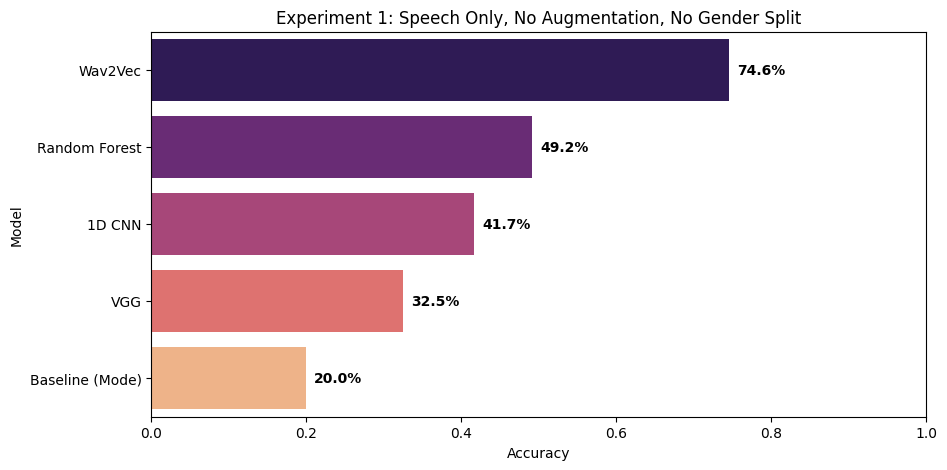

In [14]:
# ================
# RESULTS
# ================

print("\n Speech Only Results")
df_res = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values('Accuracy', ascending=False)
print(df_res)

winner = df_res.iloc[0]
print(f"\n Winner: {winner['Model']} ({winner['Accuracy']:.2%})")

plt.figure(figsize=(10, 5))
sns.barplot(x='Accuracy', y='Model', data=df_res, palette='magma')
plt.xlim(0, 1.0)
for i, v in enumerate(df_res['Accuracy']):
    plt.text(v + 0.01, i, f"{v:.1%}", va='center', fontweight='bold')
plt.title("Experiment 1: Speech Only, No Augmentation, No Gender Split")
plt.show()